In [1]:
from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder.appName("DataWarehouseAnalysis").getOrCreate()

**Loading Data**

In [3]:
import os

# Directory containing CSV files
directory_path = "C:\\Users\\rasman khurshid\\Desktop\\Data Processing\\Dataset_Final\\DataSet_final"

# List all CSV files in the directory
csv_files = [file for file in os.listdir(directory_path) if file.endswith('.csv')]

# Initialize a dictionary to hold DataFrames
dataframes = {}

for file in csv_files:
    file_path = os.path.join(directory_path, file)
    df_name = file.replace('.csv', '')  # Creating a DataFrame name from file name
    dataframes[df_name] = spark.read.csv(file_path, header=True, inferSchema=True)


**Data Cleaning** 

In [48]:
from pyspark.sql.functions import col, count, when

missing_values = {}
for df_name, df in dataframes.items():
    # Count missing values for each column
    missing_count = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).collect()
    missing_values[df_name] = {col: val for col, val in zip(df.columns, missing_count[0])}

# The dictionary 'missing_values' will have the count of missing values for each column in each DataFrame



**Missing Values in each DataFrame**

In [50]:
from pyspark.sql.functions import col, count, when

missing_values = {}
for df_name, df in dataframes.items():
    # Count missing values for each column
    missing_count = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).collect()
    missing_values[df_name] = {col: val for col, val in zip(df.columns, missing_count[0])}

# The dictionary 'missing_values' will have the count of missing values for each column in each DataFrame



**Dropping Unnecessary Columns from Customer Table**

In [6]:

# Dropping 'MiddleName', 'AddressLine2' and 'Title' columns from 'DimCustomer'
dimCustomer = dataframes['DimCustomer']
dimCustomer = dimCustomer.drop('MiddleName', 'AddressLine2', 'Title', 'Suffix')

# Update the DataFrame dictionary
dataframes['DimCustomer'] = dimCustomer


**Handling Outliers** 

In [7]:
from pyspark.sql.functions import lit, percentile_approx, col

dimCustomer = dataframes['DimCustomer']

# List of numerical columns to check for outliers
numerical_columns = ['YearlyIncome', 'TotalChildren', 'NumberChildrenAtHome'] 

outliers = {}
for col_name in numerical_columns:
    # Calculate the lower and upper quartiles
    bounds = dimCustomer.stat.approxQuantile(col_name, [0.25, 0.75], 0.05)
    IQR = bounds[1] - bounds[0]

    # Define lower and upper bounds for outliers
    lower_bound = bounds[0] - 1.5 * IQR
    upper_bound = bounds[1] + 1.5 * IQR

    # Count outliers
    outliers_below = dimCustomer.filter(col(col_name) < lit(lower_bound)).count()
    outliers_above = dimCustomer.filter(col(col_name) > lit(upper_bound)).count()

    # Store the count of outliers
    outliers[col_name] = {'below': outliers_below, 'above': outliers_above}

# Print the results
for col_name, counts in outliers.items():
    print(f"Column: {col_name}")
    print(f"  Outliers below lower bound: {counts['below']}")
    print(f"  Outliers above upper bound: {counts['above']}\n")
    



Column: YearlyIncome
  Outliers below lower bound: 0
  Outliers above upper bound: 309

Column: TotalChildren
  Outliers below lower bound: 0
  Outliers above upper bound: 0

Column: NumberChildrenAtHome
  Outliers below lower bound: 0
  Outliers above upper bound: 3260



The 'YearlyIncome' and 'NumberChildrenAtHome' fields have a significant number of outliers above their respective upper bounds. This suggests that there are customers with unusually high yearly incomes and a number of children at home compared to the general population of the dataset. The absence of outliers for 'TotalChildren' suggests that the distribution of this variable is relatively tight, with most data points falling within a normal range.

**Handling Outliers through Capping in DimCustomer**

In [8]:

    # Cap outliers
    dimCustomer = dimCustomer.withColumn(col_name, when(col(col_name) < lit(lower_bound), lit(lower_bound))
                                               .when(col(col_name) > lit(upper_bound), lit(upper_bound))
                                               .otherwise(col(col_name)))

# Update the DataFrame in dictionary
dataframes['DimCustomer'] = dimCustomer


**Counting Outliers again**

In [9]:
dimCustomer = dataframes['DimCustomer']

# List of numerical columns to check for outliers
numerical_columns = ['YearlyIncome', 'TotalChildren', 'NumberChildrenAtHome'] 

outliers = {}
for col_name in numerical_columns:
    # Calculate the lower and upper quartiles
    bounds = dimCustomer.stat.approxQuantile(col_name, [0.25, 0.75], 0.05)
    IQR = bounds[1] - bounds[0]

    # Define lower and upper bounds for outliers
    lower_bound = bounds[0] - 1.5 * IQR
    upper_bound = bounds[1] + 1.5 * IQR

    # Count outliers
    outliers_below = dimCustomer.filter(col(col_name) < lit(lower_bound)).count()
    outliers_above = dimCustomer.filter(col(col_name) > lit(upper_bound)).count()

    # Store the count of outliers
    outliers[col_name] = {'below': outliers_below, 'above': outliers_above}

# Print the results
for col_name, counts in outliers.items():
    print(f"Column: {col_name}")
    print(f"  Outliers below lower bound: {counts['below']}")
    print(f"  Outliers above upper bound: {counts['above']}\n")
    



Column: YearlyIncome
  Outliers below lower bound: 0
  Outliers above upper bound: 309

Column: TotalChildren
  Outliers below lower bound: 0
  Outliers above upper bound: 0

Column: NumberChildrenAtHome
  Outliers below lower bound: 0
  Outliers above upper bound: 0



The output shows that in the 'DimCustomer' dataset, 'YearlyIncome' has 309 outliers above the upper bound, while 'TotalChildren' and 'NumberChildrenAtHome' have no outliers either below the lower bound or above the upper bound.

**Checking Outliers in FactInternetSales**

In [10]:
factInternetSales = dataframes['FactInternetSales']

# List of numerical columns to check for outliers
numerical_columns1 = ['OrderQuantity', 'UnitPrice', 'ExtendedAmount', 'SalesAmount', 'TaxAmt', 'Freight'] 

outliers = {}
for col_name in numerical_columns1:
    # Calculate the lower and upper quartiles
    bounds = factInternetSales.stat.approxQuantile(col_name, [0.25, 0.75], 0.05)
    IQR = bounds[1] - bounds[0]

    # Define lower and upper bounds for outliers
    lower_bound = bounds[0] - 1.5 * IQR
    upper_bound = bounds[1] + 1.5 * IQR

    # Count outliers
    outliers_below = factInternetSales.filter(col(col_name) < lit(lower_bound)).count()
    outliers_above = factInternetSales.filter(col(col_name) > lit(upper_bound)).count()

    # Store the count of outliers
    outliers[col_name] = {'below': outliers_below, 'above': outliers_above}

# Print the results
for col_name, counts in outliers.items():
    print(f"Column: {col_name}")
    print(f"  Outliers below lower bound: {counts['below']}")
    print(f"  Outliers above upper bound: {counts['above']}\n")


Column: OrderQuantity
  Outliers below lower bound: 0
  Outliers above upper bound: 0

Column: UnitPrice
  Outliers below lower bound: 0
  Outliers above upper bound: 15454

Column: ExtendedAmount
  Outliers below lower bound: 0
  Outliers above upper bound: 15454

Column: SalesAmount
  Outliers below lower bound: 0
  Outliers above upper bound: 15454

Column: TaxAmt
  Outliers below lower bound: 0
  Outliers above upper bound: 15454

Column: Freight
  Outliers below lower bound: 0
  Outliers above upper bound: 15454



**Handling Outliers in FactInternetSales using Segmentation:**
    High values in FactInternetSales (like UnitPrice, SalesAmount, etc.) may represent large, legitimate transactions (e.g., bulk purchases, high-value items). Removing these outliers might lead to losing insights into a potentially significant customer segment. Segmenting sales data into different categories, such as regular sales and high-value sales allows for more nuanced analysis and understanding of different customer behaviors. I will perform segmentation later. 

**Exploratory Data Analysis (EDA) of DimCustomer**

In [11]:
import pandas as pd 
import matplotlib.pyplot as plt # For plotting
import numpy as np
import seaborn as sns

dim_customer_df = dataframes['DimCustomer']
# Convert PySpark DataFrame to Pandas DataFrame for tabular view
pandas_dim_customer_df = dim_customer_df.toPandas()

# Display the first few rows in a tabular format
pandas_dim_customer_df.head()

,CustomerKey,GeographyKey,CustomerAlternateKey,FirstName,LastName,NameStyle,BirthDate,MaritalStatus,Gender,EmailAddress,...,FrenchEducation,EnglishOccupation,SpanishOccupation,FrenchOccupation,HouseOwnerFlag,NumberCarsOwned,AddressLine1,Phone,DateFirstPurchase,CommuteDistance
0,11000,26,AW00011000,Jon,Yang,False,4/8/1966,M,M,jon24@adventure-works.com,...,Bac + 4,Professional,Profesional,Cadre,1,0,3761 N. 14th St,1 (11) 500 555-0162,7/22/2005,1-2 Miles
1,11001,37,AW00011001,Eugene,Huang,False,5/14/1965,S,M,eugene10@adventure-works.com,...,Bac + 4,Professional,Profesional,Cadre,0,1,2243 W St.,1 (11) 500 555-0110,7/18/2005,0-1 Miles
2,11002,31,AW00011002,Ruben,Torres,False,8/12/1965,M,M,ruben35@adventure-works.com,...,Bac + 4,Professional,Profesional,Cadre,1,1,5844 Linden Land,1 (11) 500 555-0184,7/10/2005,2-5 Miles
3,11003,11,AW00011003,Christy,Zhu,False,2/15/1968,S,F,christy12@adventure-works.com,...,Bac + 4,Professional,Profesional,Cadre,0,1,1825 Village Pl.,1 (11) 500 555-0162,7/1/2005,5-10 Miles
4,11004,19,AW00011004,Elizabeth,Johnson,False,8/8/1968,S,F,elizabeth5@adventure-works.com,...,Bac + 4,Professional,Profesional,Cadre,1,4,7553 Harness Circle,1 (11) 500 555-0131,7/26/2005,1-2 Miles


In [12]:
pandas_dim_customer_df.describe()

,CustomerKey,GeographyKey,YearlyIncome,TotalChildren,NumberChildrenAtHome,HouseOwnerFlag,NumberCarsOwned
count,18484.000000,18484.000000,18484.000000,18484.000000,18484.000000,18484.000000,18484.000000
mean,20241.500000,257.956287,57305.777970,1.844352,0.752326,0.676369,1.502705
std,5336.015523,196.531062,32285.841703,1.612408,1.012959,0.467874,1.138394
min,11000.000000,2.000000,10000.000000,0.000000,0.000000,0.000000,0.000000
25%,15620.750000,62.000000,30000.000000,0.000000,0.000000,0.000000,1.000000
50%,20241.500000,240.000000,60000.000000,2.000000,0.000000,1.000000,2.000000
75%,24862.250000,345.000000,70000.000000,3.000000,2.000000,1.000000,2.000000
max,29483.000000,654.000000,170000.000000,5.000000,2.500000,1.000000,4.000000


In [13]:
pandas_dim_customer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18484 entries, 0 to 18483
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CustomerKey           18484 non-null  int32  
 1   GeographyKey          18484 non-null  int32  
 2   CustomerAlternateKey  18484 non-null  object 
 3   FirstName             18484 non-null  object 
 4   LastName              18484 non-null  object 
 5   NameStyle             18484 non-null  bool   
 6   BirthDate             18484 non-null  object 
 7   MaritalStatus         18484 non-null  object 
 8   Gender                18484 non-null  object 
 9   EmailAddress          18484 non-null  object 
 10  YearlyIncome          18484 non-null  int32  
 11  TotalChildren         18484 non-null  int32  
 12  NumberChildrenAtHome  18484 non-null  float64
 13  EnglishEducation      18484 non-null  object 
 14  SpanishEducation      18484 non-null  object 
 15  FrenchEducation    

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1200x1600 with 0 Axes>

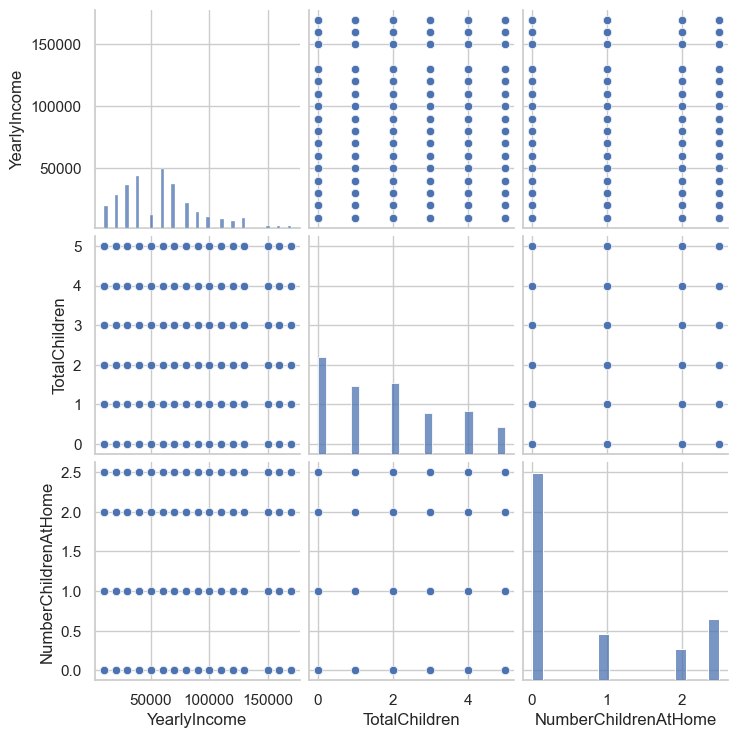

In [14]:
# Selecting specific columns to create a new DataFrame
new_df = pandas_dim_customer_df[['YearlyIncome', 'TotalChildren', 'NumberChildrenAtHome']]
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 16))
sns.pairplot(new_df)
plt.show()

**Here are the observations:**

**'YearlyIncome' Distribution:** The histogram for 'YearlyIncome' indicates a right-skewed distribution, suggesting that most customers have a lower income, with fewer customers earning higher incomes.

**'TotalChildren' Distribution:** The 'TotalChildren' histogram shows a relatively uniform distribution for lower counts of children, but it decreases as the number of children increases, indicating fewer customers have a larger number of children.

**'NumberChildrenAtHome' Distribution:** The histogram for 'NumberChildrenAtHome' indicates that a majority of customers have no children at home or a small number, with the frequency decreasing as the number of children at home increases.

**'YearlyIncome' vs. 'TotalChildren':** The scatter plot does not indicate a clear correlation between 'YearlyIncome' and 'TotalChildren'. There is a wide spread of incomes for customers with few children, and as the number of children increases, the range of incomes seems to narrow, but this could be due to fewer data points.

**'YearlyIncome' vs. 'NumberChildrenAtHome':** Similar to 'TotalChildren', there is no apparent correlation between 'YearlyIncome' and 'NumberChildrenAtHome'. Incomes are spread across the range for customers with few children at home.

**'TotalChildren' vs. 'NumberChildrenAtHome':** The scatter plot shows a pattern where as the 'TotalChildren' increases, 'NumberChildrenAtHome' also tends to increase, which is an expected relationship. However, there are many instances where customers have more 'TotalChildren' but none or fewer 'NumberChildrenAtHome', which may indicate children who have grown up and moved out.

[0, 1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5]


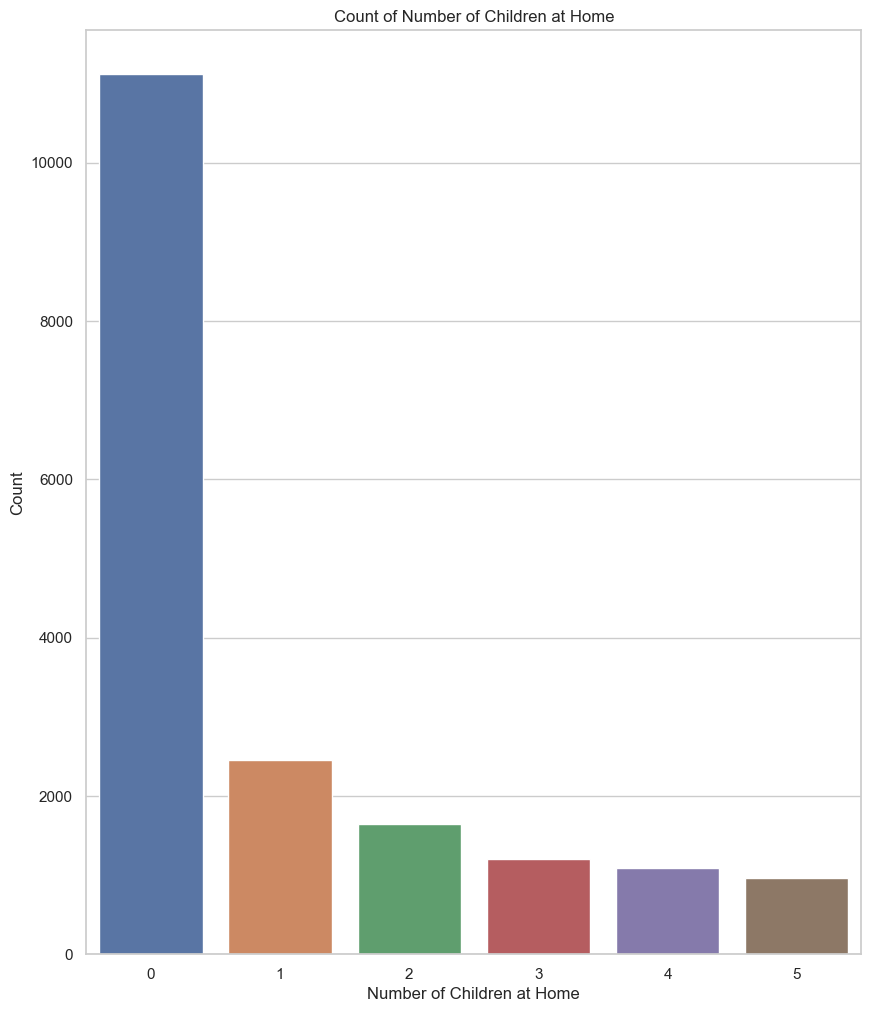

In [51]:
import pandas as pd

# File path
file_path = 'C:/Users/rasman khurshid/Desktop/Data Processing/Dataset_Final/DataSet_final/DimCustomer.csv'

# Try different encodings if 'utf-8' doesn't work
try:
    df = pd.read_csv(file_path, encoding='utf-8')
except UnicodeDecodeError:
    try:
        df = pd.read_csv(file_path, encoding='latin1')
    except UnicodeDecodeError:
        df = pd.read_csv(file_path, encoding='iso-8859-1')  # or try 'cp1252'
        
print(sorted(df['NumberChildrenAtHome'].unique()))

# Convert the 'NumberChildrenAtHome' from float to int
df['NumberChildrenAtHome'] = df['NumberChildrenAtHome'].astype(int)

# Now check the unique values again
print(sorted(df['NumberChildrenAtHome'].unique()))


# Set the aesthetic style of the plots
sns.set_theme(style="whitegrid")

# Increase the figure size to make the plot wider
plt.figure(figsize=(10, 12))  # Adjust the size as needed

# Create a bar plot for 'NumberChildrenAtHome' column
ax = sns.countplot(x='NumberChildrenAtHome', data=df)

# Set the title and labels of the plot
ax.set_title('Count of Number of Children at Home')
ax.set_xlabel('Number of Children at Home')
ax.set_ylabel('Count')

# Show the plot
plt.show()




## Distribution of Total Children Across Yearly Income

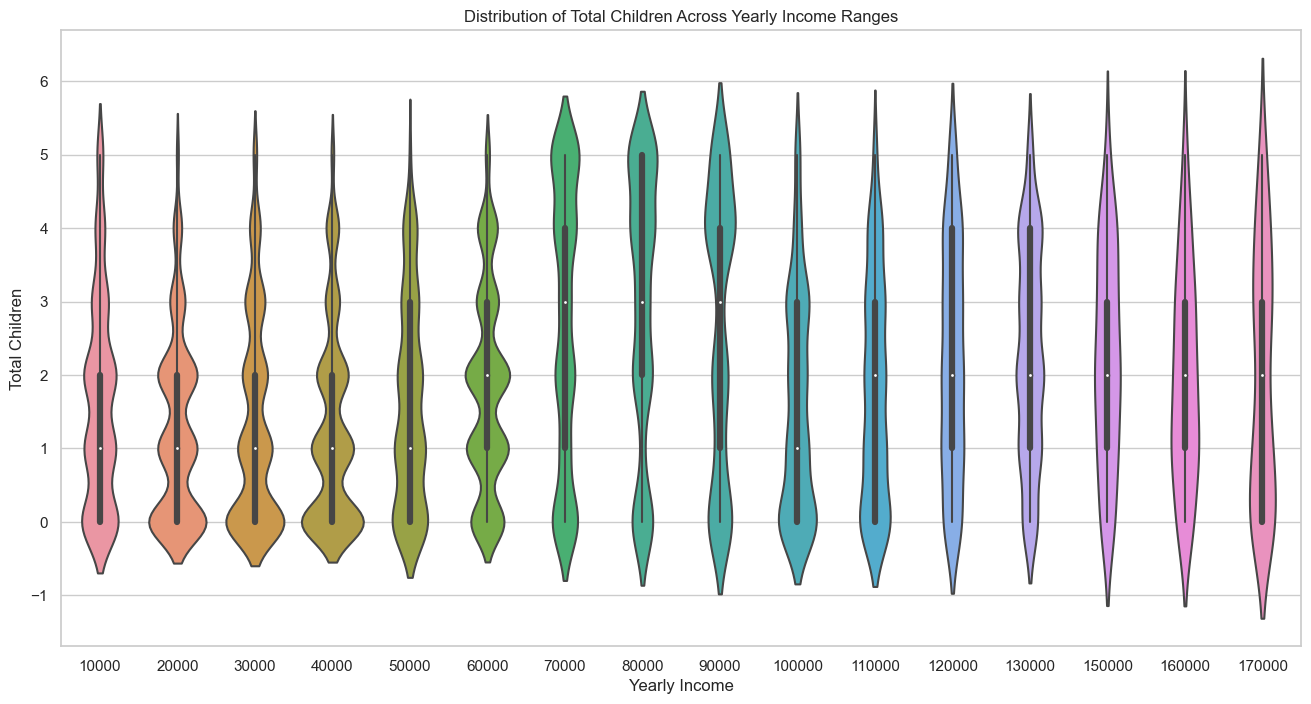

In [17]:
plt.figure(figsize=(16, 8))
sns.violinplot(x='YearlyIncome', y='TotalChildren', data=pandas_dim_customer_df)
plt.title('Distribution of Total Children Across Yearly Income Ranges')
plt.xlabel('Yearly Income')
plt.ylabel('Total Children')
plt.show()

**Analysis:** The violin plot visualizes the distribution of 'Total Children' across various 'Yearly Income' ranges. Each violin shape corresponds to a different income bracket, showing the distribution of family sizes within that bracket. The plot suggests a relatively consistent median of around 1 to 2 children across all income ranges, as indicated by the white dot within each violin. The thickness of each violin indicates the density of data points at different counts of 'Total Children', with the thickest part representing the most common value. Notably, there are no significant outliers or extreme variations in family size across different income levels, as all violins maintain a similar shape and width throughout their length. The consistency across the income ranges suggests there is no strong correlation between the number of children and yearly income within this dataset. The range of 'Total Children' is mostly between 0 and 3 for all income levels, indicating that most families in this dataset have fewer than 3 children, regardless of income.


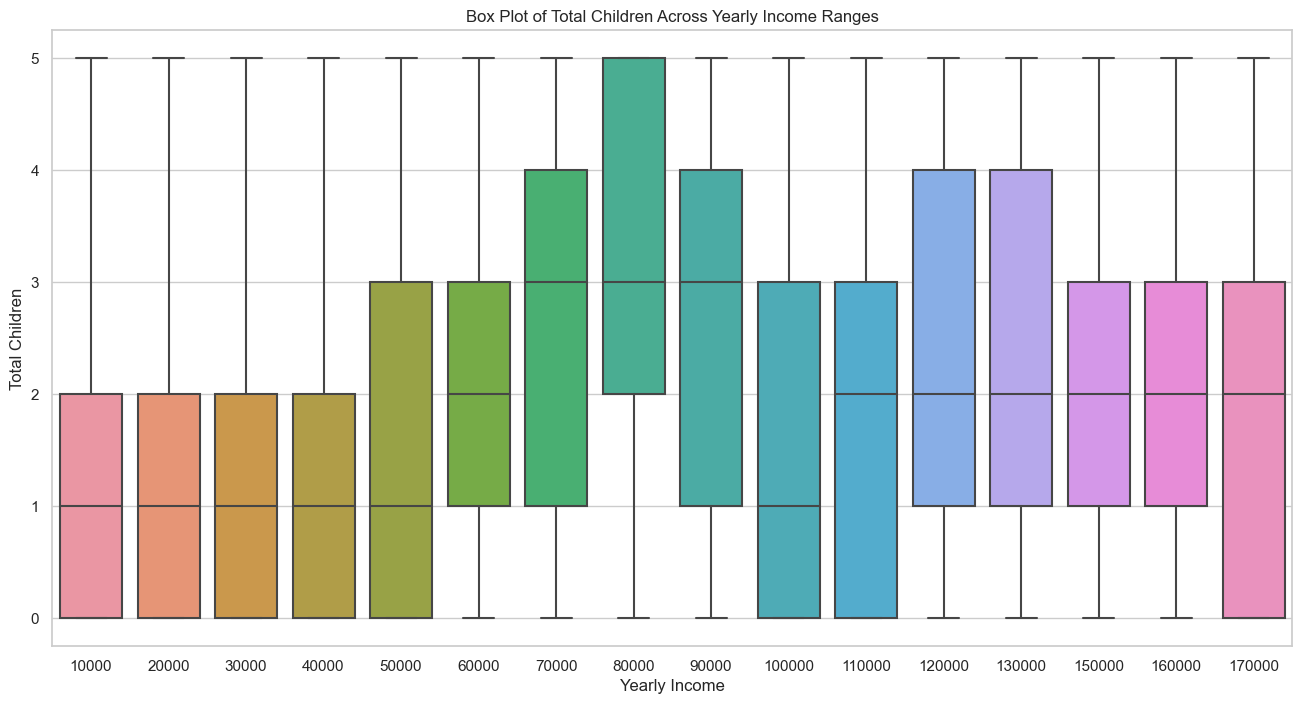

In [18]:
plt.figure(figsize=(16, 8))
sns.boxplot(x='YearlyIncome', y='TotalChildren', data=pandas_dim_customer_df)
plt.title('Box Plot of Total Children Across Yearly Income Ranges')
plt.xlabel('Yearly Income')
plt.ylabel('Total Children')
plt.show()

**Age Distribution of Customers**

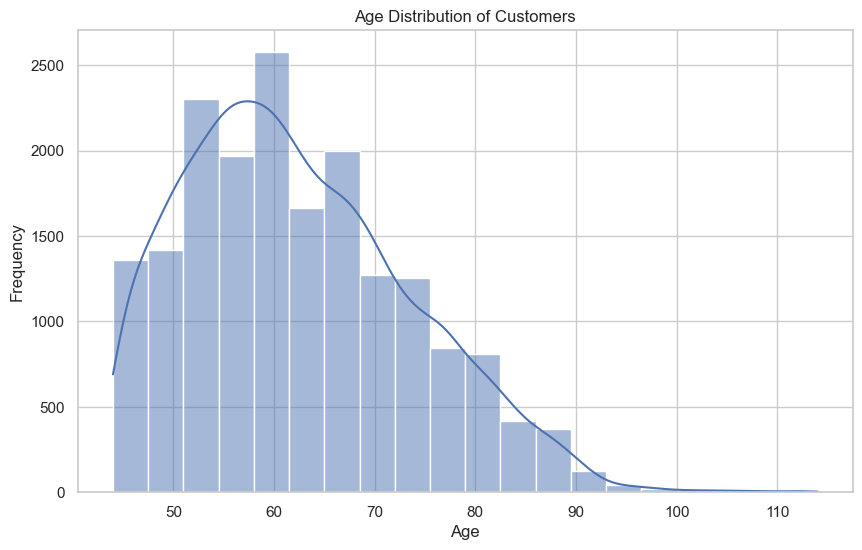

In [19]:
from datetime import datetime

# Convert BirthDate from string to datetime
pandas_dim_customer_df['BirthDate'] = pd.to_datetime(pandas_dim_customer_df['BirthDate'])

# Calculate age
current_year = datetime.now().year
pandas_dim_customer_df['Age'] = current_year - pandas_dim_customer_df['BirthDate'].dt.year
# Convert BirthDate from string to datetime
pandas_dim_customer_df['BirthDate'] = pd.to_datetime(pandas_dim_customer_df['BirthDate'])

plt.figure(figsize=(10, 6))
sns.histplot(pandas_dim_customer_df['Age'], bins=20, kde=True)
plt.title('Age Distribution of Customers')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()


**Histogram Analysis:** 
The distribution of age appears to be right-skewed, meaning there are more younger customers than older ones.
The bulk of the customers seem to fall within the range of approximately 50 to 70 years old.
There is a long tail extending into the older age ranges, suggesting a smaller number of much older customers. The skew towards younger ages suggests a potentially significant segment of the market. Marketing strategies targeting this demographic could focus on products or services that appeal to a younger audience.

**Exploratory Data Analysis (EDA) for DimGeography**

In [20]:
dim_geo_df = dataframes['DimGeography']
# Convert PySpark DataFrame to Pandas DataFrame for tabular view
pandas_dim_geo_df = dim_geo_df.toPandas()

# Display the first few rows in a tabular format
pandas_dim_geo_df.head()

,GeographyKey,City,StateProvinceCode,StateProvinceName,CountryRegionCode,EnglishCountryRegionName,SpanishCountryRegionName,FrenchCountryRegionName,PostalCode,SalesTerritoryKey,IpAddressLocator
0,1,Alexandria,NSW,New South Wales,AU,Australia,Australia,Australie,2015,9,198.51.100.2
1,2,Coffs Harbour,NSW,New South Wales,AU,Australia,Australia,Australie,2450,9,198.51.100.3
2,3,Darlinghurst,NSW,New South Wales,AU,Australia,Australia,Australie,2010,9,198.51.100.4
3,4,Goulburn,NSW,New South Wales,AU,Australia,Australia,Australie,2580,9,198.51.100.5
4,5,Lane Cove,NSW,New South Wales,AU,Australia,Australia,Australie,1597,9,198.51.100.6


In [21]:
pandas_dim_geo_df.describe()

,GeographyKey,SalesTerritoryKey
count,655.000000,655.000000
mean,328.000000,5.114504
std,189.226496,2.744027
min,1.000000,1.000000
25%,164.500000,3.000000
50%,328.000000,5.000000
75%,491.500000,7.000000
max,655.000000,10.000000


In [22]:
pandas_dim_geo_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 655 entries, 0 to 654
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   GeographyKey              655 non-null    int32 
 1   City                      655 non-null    object
 2   StateProvinceCode         655 non-null    object
 3   StateProvinceName         655 non-null    object
 4   CountryRegionCode         655 non-null    object
 5   EnglishCountryRegionName  655 non-null    object
 6   SpanishCountryRegionName  655 non-null    object
 7   FrenchCountryRegionName   655 non-null    object
 8   PostalCode                655 non-null    object
 9   SalesTerritoryKey         655 non-null    int32 
 10  IpAddressLocator          655 non-null    object
dtypes: int32(2), object(9)
memory usage: 51.3+ KB


**Understanding how customers are distributed geographically**

C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


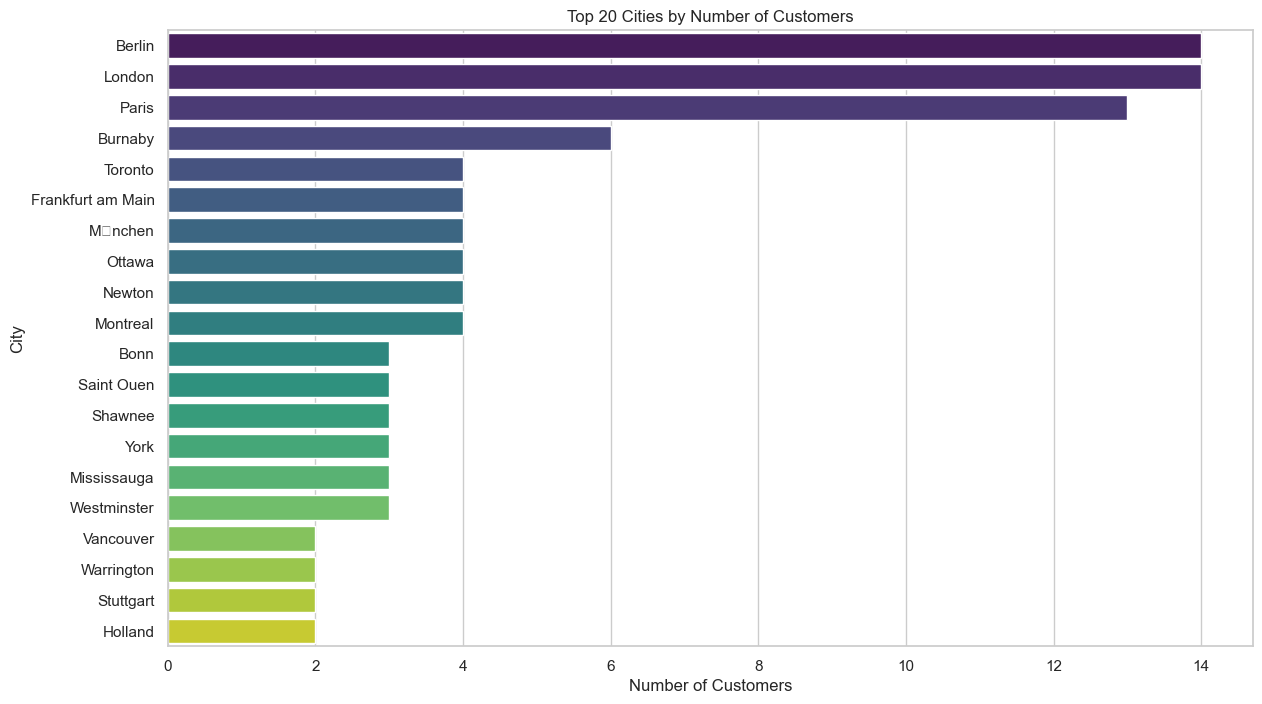

In [23]:

# Distribution by City
city_counts = pandas_dim_geo_df['City'].value_counts()
# Limit to top N cities for better readability
top_cities = city_counts.head(20)  # Adjust N as needed

plt.figure(figsize=(14, 8))  # Increase figure size
sns.barplot(y=top_cities.index, x=top_cities.values, palette='viridis')  # Horizontal bar chart
plt.title('Top 20 Cities by Number of Customers')
plt.xlabel('Number of Customers')
plt.ylabel('City')
plt.show()




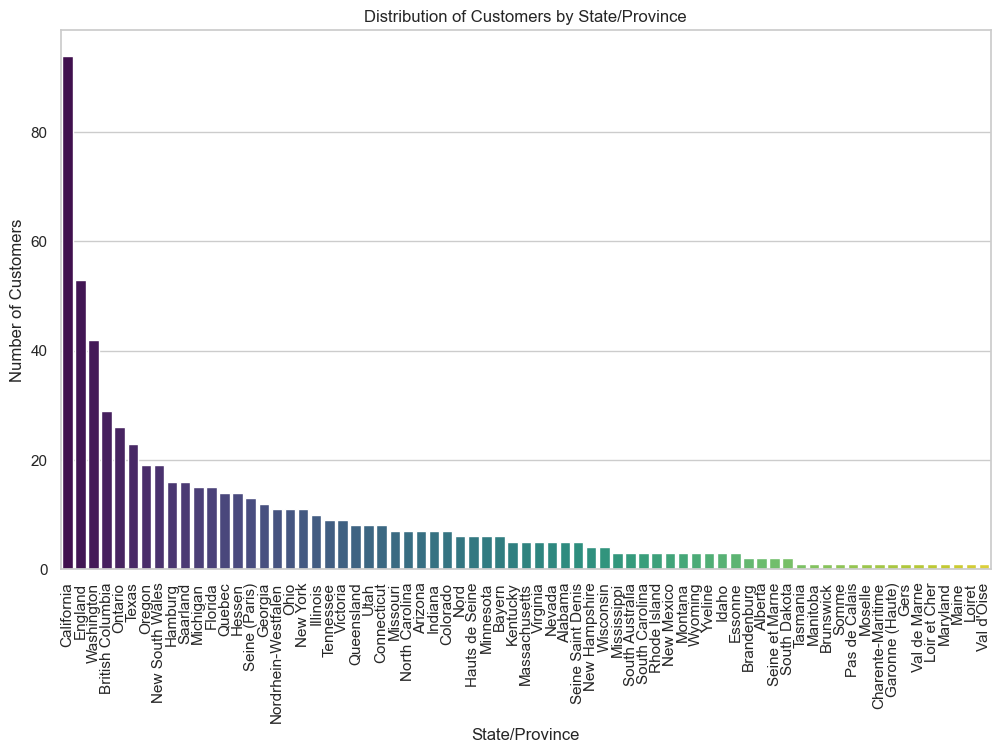

In [24]:
# Distribution by StateProvinceName
state_counts = pandas_dim_geo_df['StateProvinceName'].value_counts()
plt.figure(figsize=(12, 7))
sns.barplot(x=state_counts.index, y=state_counts.values, palette='viridis') 
plt.title('Distribution of Customers by State/Province')
plt.xlabel('State/Province')
plt.ylabel('Number of Customers')
plt.xticks(rotation=90)  
plt.show()



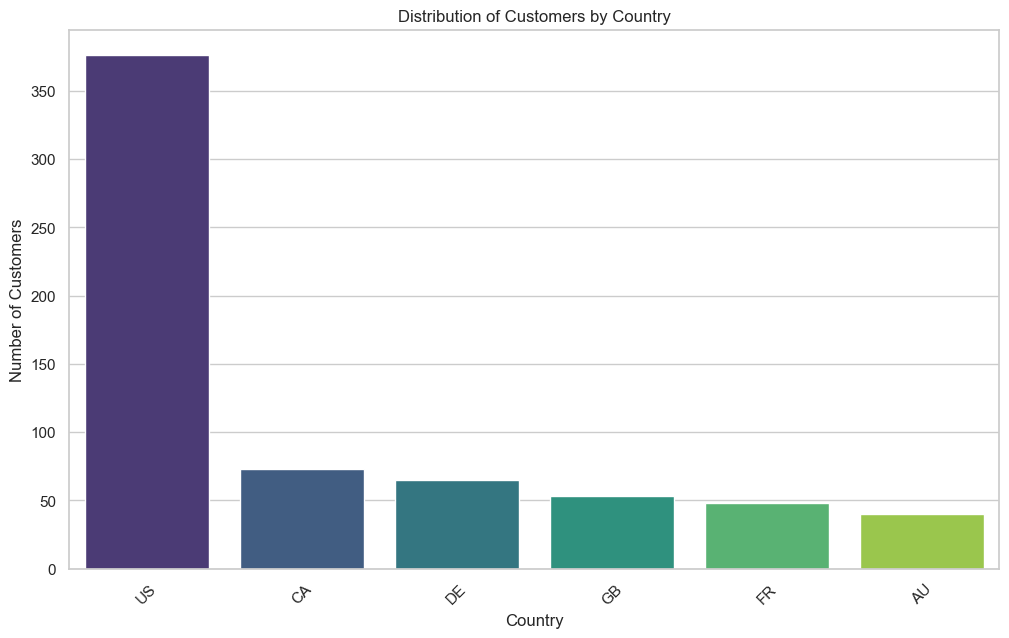

In [25]:

# Distribution by CountryRegionCode
country_counts = pandas_dim_geo_df['CountryRegionCode'].value_counts()
plt.figure(figsize=(12, 7))
sns.barplot(x=country_counts.index, y=country_counts.values, palette='viridis') 
plt.title('Distribution of Customers by Country')
plt.xlabel('Country')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45) 
plt.show()

**Analysis:** Together, these plots provide an understanding of where the customer base is concentrated. The US dominates the customer distribution, with significant counts in key European cities and Canadian provinces.

**Exploratory Data Analysis (EDA) for DimSalesTerritory**

In [26]:
dim_saleTerritory_df = dataframes['DimSalesTerritory']
# Convert PySpark DataFrame to Pandas DataFrame for tabular view
pandas_dim_saleTerritory_df = dim_saleTerritory_df.toPandas()

# Display the first few rows in a tabular format
pandas_dim_saleTerritory_df.head()

,SalesTerritoryKey,SalesTerritoryAlternateKey,SalesTerritoryRegion,SalesTerritoryCountry,SalesTerritoryGroup
0,1,1,Northwest,United States,North America
1,2,2,Northeast,United States,North America
2,3,3,Central,United States,North America
3,4,4,Southwest,United States,North America
4,5,5,Southeast,United States,North America


In [27]:
pandas_dim_saleTerritory_df.describe()

,SalesTerritoryKey,SalesTerritoryAlternateKey
count,11.000000,11.000000
mean,6.000000,5.000000
std,3.316625,3.316625
min,1.000000,0.000000
25%,3.500000,2.500000
50%,6.000000,5.000000
75%,8.500000,7.500000
max,11.000000,10.000000


In [28]:
pandas_dim_saleTerritory_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 5 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   SalesTerritoryKey           11 non-null     int32 
 1   SalesTerritoryAlternateKey  11 non-null     int32 
 2   SalesTerritoryRegion        11 non-null     object
 3   SalesTerritoryCountry       11 non-null     object
 4   SalesTerritoryGroup         11 non-null     object
dtypes: int32(2), object(3)
memory usage: 484.0+ bytes


**Exploratory Data Analysis (EDA) for FactInternetSales**

In [29]:
dim_factInternet_df = dataframes['FactInternetSales']
# Convert PySpark DataFrame to Pandas DataFrame for tabular view
pandas_dim_factInternet_df = dim_factInternet_df.toPandas()

# Display the first few rows in a tabular format
pandas_dim_factInternet_df.head()

,ProductKey,OrderDateKey,DueDateKey,ShipDateKey,CustomerKey,PromotionKey,CurrencyKey,SalesTerritoryKey,SalesOrderNumber,SalesOrderLineNumber,...,ProductStandardCost,TotalProductCost,SalesAmount,TaxAmt,Freight,CarrierTrackingNumber,CustomerPONumber,OrderDate,DueDate,ShipDate
0,310,20101229,20110110,20110105,21768,1,19,6,SO43697,1,...,2171.2942,2171.2942,3578.2700,286.2616,89.4568,NULL,NULL,00:00.0,00:00.0,00:00.0
1,346,20101229,20110110,20110105,28389,1,39,7,SO43698,1,...,1912.1544,1912.1544,3399.9900,271.9992,84.9998,NULL,NULL,00:00.0,00:00.0,00:00.0
2,346,20101229,20110110,20110105,25863,1,100,1,SO43699,1,...,1912.1544,1912.1544,3399.9900,271.9992,84.9998,NULL,NULL,00:00.0,00:00.0,00:00.0
3,336,20101229,20110110,20110105,14501,1,100,4,SO43700,1,...,413.1463,413.1463,699.0982,55.9279,17.4775,NULL,NULL,00:00.0,00:00.0,00:00.0
4,346,20101229,20110110,20110105,11003,1,6,9,SO43701,1,...,1912.1544,1912.1544,3399.9900,271.9992,84.9998,NULL,NULL,00:00.0,00:00.0,00:00.0


In [30]:
pandas_dim_factInternet_df.describe()

,ProductKey,OrderDateKey,DueDateKey,ShipDateKey,CustomerKey,PromotionKey,CurrencyKey,SalesTerritoryKey,SalesOrderLineNumber,RevisionNumber,OrderQuantity,UnitPrice,ExtendedAmount,UnitPriceDiscountPct,DiscountAmount,ProductStandardCost,TotalProductCost,SalesAmount,TaxAmt,Freight
count,60398.000000,6.039800e+04,6.039800e+04,6.039800e+04,60398.000000,60398.000000,60398.000000,60398.000000,60398.000000,60398.0,60398.0,60398.000000,60398.000000,60398.0,60398.0,60398.000000,60398.000000,60398.000000,60398.000000,60398.000000
mean,437.557932,2.012973e+07,2.013010e+07,2.012994e+07,18841.685420,1.041839,69.845326,6.244462,1.886321,1.0,1.0,486.086911,486.086911,0.0,0.0,286.065657,286.065657,486.086911,38.886954,12.152217
std,118.088390,4.745050e+03,4.985453e+03,4.851061e+03,5432.430404,0.342605,42.146363,2.961150,1.016328,0.0,0.0,928.489892,928.489892,0.0,0.0,552.457641,552.457641,928.489892,74.279193,23.212248
min,214.000000,2.010123e+07,2.011011e+07,2.011010e+07,11000.000000,1.000000,6.000000,1.000000,1.000000,1.0,1.0,2.290000,2.290000,0.0,0.0,0.856500,0.856500,2.290000,0.183200,0.057300
25%,359.000000,2.013040e+07,2.013042e+07,2.013041e+07,14003.000000,1.000000,19.000000,4.000000,1.000000,1.0,1.0,7.950000,7.950000,0.0,0.0,2.973300,2.973300,7.950000,0.636000,0.198800
50%,479.000000,2.013071e+07,2.013073e+07,2.013072e+07,18143.000000,1.000000,100.000000,7.000000,2.000000,1.0,1.0,29.990000,29.990000,0.0,0.0,11.216300,11.216300,29.990000,2.399200,0.749800
75%,529.000000,2.013102e+07,2.013103e+07,2.013102e+07,23429.750000,1.000000,100.000000,9.000000,2.000000,1.0,1.0,539.990000,539.990000,0.0,0.0,294.579700,294.579700,539.990000,43.199200,13.499800
max,606.000000,2.014013e+07,2.014021e+07,2.014020e+07,29483.000000,14.000000,100.000000,10.000000,8.000000,1.0,1.0,3578.270000,3578.270000,0.0,0.0,2171.294200,2171.294200,3578.270000,286.261600,89.456800


In [31]:
pandas_dim_factInternet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60398 entries, 0 to 60397
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ProductKey             60398 non-null  int32  
 1   OrderDateKey           60398 non-null  int32  
 2   DueDateKey             60398 non-null  int32  
 3   ShipDateKey            60398 non-null  int32  
 4   CustomerKey            60398 non-null  int32  
 5   PromotionKey           60398 non-null  int32  
 6   CurrencyKey            60398 non-null  int32  
 7   SalesTerritoryKey      60398 non-null  int32  
 8   SalesOrderNumber       60398 non-null  object 
 9   SalesOrderLineNumber   60398 non-null  int32  
 10  RevisionNumber         60398 non-null  int32  
 11  OrderQuantity          60398 non-null  int32  
 12  UnitPrice              60398 non-null  float64
 13  ExtendedAmount         60398 non-null  float64
 14  UnitPriceDiscountPct   60398 non-null  int32  
 15  Di

## Sales Performance by Sales Territoty Region

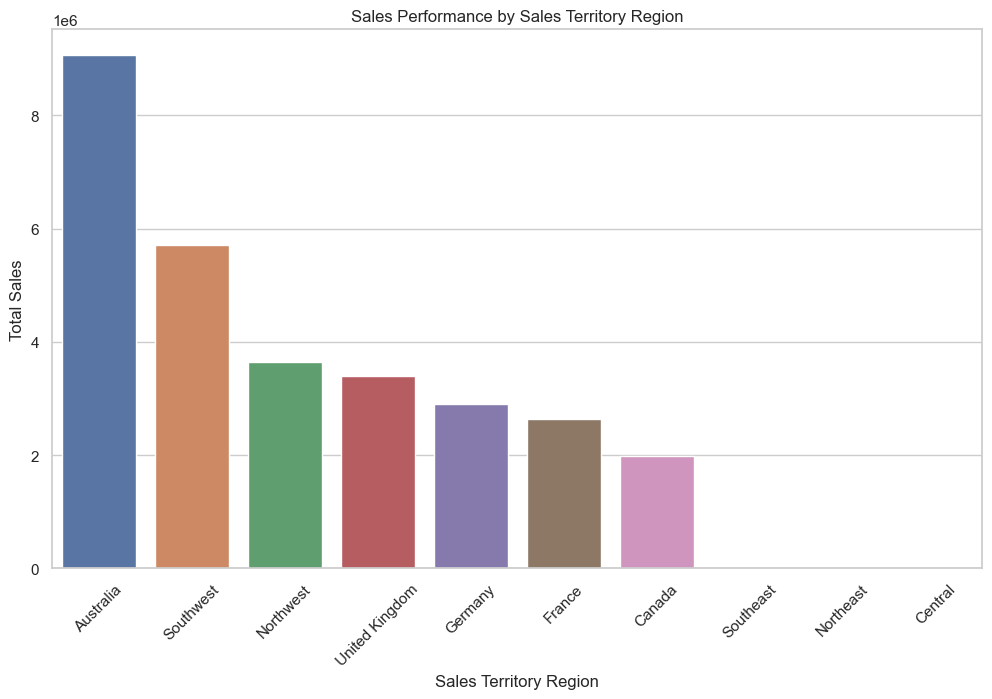

In [52]:
# Merge the sales data with the sales territory data on SalesTerritoryKey
merged_df = pd.merge(pandas_dim_factInternet_df, pandas_dim_saleTerritory_df, on='SalesTerritoryKey', how='left')

# Aggregate sales by territory
sales_by_territory = merged_df.groupby('SalesTerritoryRegion')['SalesAmount'].sum().sort_values(ascending=False)

# Convert the aggregated data to a DataFrame for visualization
sales_by_territory_df = sales_by_territory.reset_index()

# Visualize sales performance by territory
plt.figure(figsize=(12, 7))
sns.barplot(x='SalesTerritoryRegion', y='SalesAmount', data=sales_by_territory_df)
plt.title('Sales Performance by Sales Territory Region')
plt.xlabel('Sales Territory Region')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.show()




A DataFrame merged_df is created by merging sales data with sales territory data on the 'SalesTerritoryKey'.
The data is then grouped by 'SalesTerritoryRegion' and the sales amounts are summed.
The aggregated sales data is sorted in descending order and reset into a new DataFrame for visualization purposes.
A bar plot is created with Seaborn, showing 'SalesTerritoryRegion' on the x-axis and 'SalesAmount' on the y-axis.
The title, axis labels, and rotation of the x-axis tick labels are set to make the chart more readable.

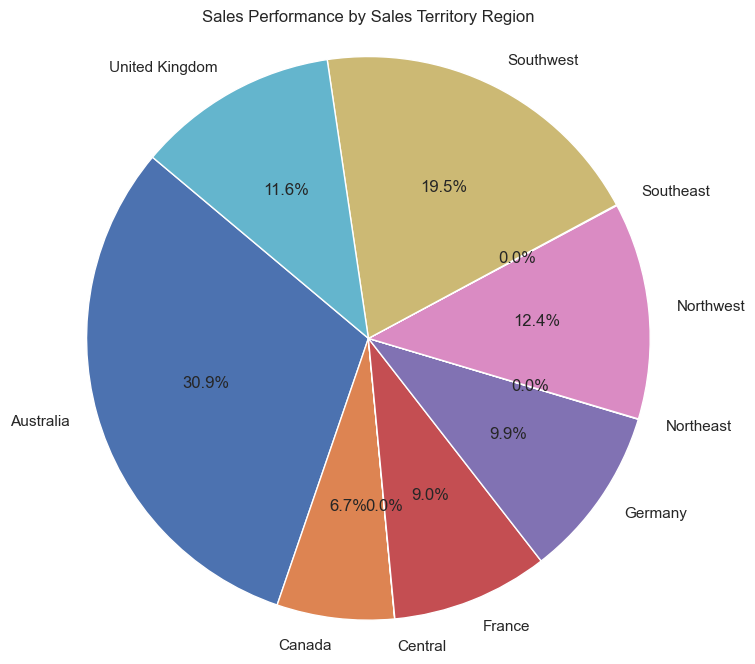

In [33]:
# Create a pie chart to visualize the sales performance by region
plt.figure(figsize=(8, 8))
plt.pie(sales_by_region, labels=sales_by_region.index, autopct='%1.1f%%', startangle=140)
plt.title('Sales Performance by Sales Territory Region')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Display the pie chart
plt.show()

These charts are useful for quickly identifying which regions are leading in sales and which are lagging, which can inform strategic business decisions such as where to allocate resources or where to implement changes to improve sales performance.

**Handling Outliers in FactInternetSales using Segmentation**

In [34]:
from pyspark.sql.functions import when, col, lit, count

factInternetSales = dataframes['FactInternetSales']

# Determine the threshold for high-value sales, e.g., 75th percentile of SalesAmount
threshold = factInternetSales.approxQuantile('SalesAmount', [0.75], 0.05)[0]

# Create a new column for segment identification
factInternetSales = factInternetSales.withColumn('SaleType', 
                                                 when(col('SalesAmount') > lit(threshold), lit('High-Value'))
                                                 .otherwise(lit('Regular')))

# Update the DataFrame in dictionary
dataframes['FactInternetSales'] = factInternetSales
# Group by the 'SaleType' and count the number of occurrences in each group
segmentation_count = factInternetSales.groupBy('SaleType').agg(count('*').alias('Count'))

factInternetSalesPandas = factInternetSales.toPandas()
factInternetSalesPandas.head()
segmentation_count_pandas = segmentation_count.toPandas()
print(segmentation_count_pandas)


     SaleType  Count
0  High-Value  17363
1     Regular  43035


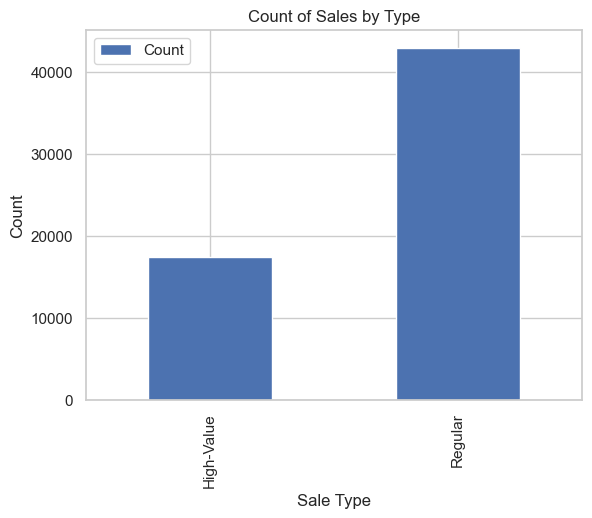

In [35]:
# Bar Chart for Segment Counts
segmentation_count_pandas.plot(kind='bar', x='SaleType', y='Count')
plt.xlabel('Sale Type')
plt.ylabel('Count')
plt.title('Count of Sales by Type')
plt.show()


# Predicting High-Value Customers using Logistic Regression 

Objective: To identify and predict high-value customers based on their purchase history, demographics, and geographic information.

Rationale: This use case is important because it helps the business focus its marketing and customer service efforts on individuals who are likely to generate the most revenue. By identifying high-value customers, the company can optimize resource allocation and tailor its strategies to retain these key customers.

**Performing Joins** 

In [36]:

customer_geo_joined = dataframes['DimCustomer'].join(dataframes['DimGeography'], 'GeographyKey', 'left')

sales_customer_joined = dataframes['FactInternetSales'].join(customer_geo_joined, 'CustomerKey', 'inner')
final_joined_df = sales_customer_joined.join(dataframes['DimSalesTerritory'], 'SalesTerritoryKey', 'left')
# Join DimCustomer with DimGeography
customer_geo_joined = dataframes['DimCustomer'].join(dataframes['DimGeography'], 'GeographyKey', 'left')

# Join FactInternetSales with the combined DimCustomer and DimGeography
sales_customer_joined = dataframes['FactInternetSales'].join(customer_geo_joined, 'CustomerKey', 'inner')

# Join the result with DimSalesTerritory
final_joined_df = sales_customer_joined.join(dataframes['DimSalesTerritory'], 'SalesTerritoryKey', 'left')
from pyspark.sql import functions as F

# Calculate the average sales amount by sales territory
avg_sales_by_territory = factInternetSales.groupBy('SalesTerritoryKey').agg(
    F.avg('SalesAmount').alias('AvgSalesAmount'),
    F.sum(F.when(col('SaleType') == 'High-Value', 1).otherwise(0)).alias('HighValueSalesCount'),
    F.count('*').alias('TotalSalesCount')
)

# Calculate the proportion of high-value sales
avg_sales_by_territory = avg_sales_by_territory.withColumn(
    'HighValueSalesProportion', 
    col('HighValueSalesCount') / col('TotalSalesCount')
)

# Join this data back to the main DataFrame
final_joined_df = final_joined_df.join(avg_sales_by_territory, 'SalesTerritoryKey', 'left')
# Drop the duplicate column after the join
# Drop one of the duplicate 'SalesTerritoryKey' columns
final_joined_df = final_joined_df.drop("SalesTerritoryKey")

final_joined_df.printSchema()


root
 |-- CustomerKey: integer (nullable = true)
 |-- ProductKey: integer (nullable = true)
 |-- OrderDateKey: integer (nullable = true)
 |-- DueDateKey: integer (nullable = true)
 |-- ShipDateKey: integer (nullable = true)
 |-- PromotionKey: integer (nullable = true)
 |-- CurrencyKey: integer (nullable = true)
 |-- SalesOrderNumber: string (nullable = true)
 |-- SalesOrderLineNumber: integer (nullable = true)
 |-- RevisionNumber: integer (nullable = true)
 |-- OrderQuantity: integer (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- ExtendedAmount: double (nullable = true)
 |-- UnitPriceDiscountPct: integer (nullable = true)
 |-- DiscountAmount: integer (nullable = true)
 |-- ProductStandardCost: double (nullable = true)
 |-- TotalProductCost: double (nullable = true)
 |-- SalesAmount: double (nullable = true)
 |-- TaxAmt: double (nullable = true)
 |-- Freight: double (nullable = true)
 |-- CarrierTrackingNumber: string (nullable = true)
 |-- CustomerPONumber: string (nul

**Data Cleaning** 

In [37]:
from pyspark.sql.functions import col

# Check for missing values in each column
missing_values = final_joined_df.select([count(when(col(c).isNull(), c)).alias(c) for c in final_joined_df.columns]).collect()
print(missing_values)

final_joined_df = final_joined_df.dropDuplicates()

final_joined_df = final_joined_df.withColumn("NumberChildrenAtHome", col("NumberChildrenAtHome").cast("int"))
# Print the data types of each column
final_joined_df.dtypes


[Row(CustomerKey=0, ProductKey=0, OrderDateKey=0, DueDateKey=0, ShipDateKey=0, PromotionKey=0, CurrencyKey=0, SalesOrderNumber=0, SalesOrderLineNumber=0, RevisionNumber=0, OrderQuantity=0, UnitPrice=0, ExtendedAmount=0, UnitPriceDiscountPct=0, DiscountAmount=0, ProductStandardCost=0, TotalProductCost=0, SalesAmount=0, TaxAmt=0, Freight=0, CarrierTrackingNumber=0, CustomerPONumber=0, OrderDate=0, DueDate=0, ShipDate=0, SaleType=0, GeographyKey=0, CustomerAlternateKey=0, FirstName=0, LastName=0, NameStyle=0, BirthDate=0, MaritalStatus=0, Gender=0, EmailAddress=0, YearlyIncome=0, TotalChildren=0, NumberChildrenAtHome=0, EnglishEducation=0, SpanishEducation=0, FrenchEducation=0, EnglishOccupation=0, SpanishOccupation=0, FrenchOccupation=0, HouseOwnerFlag=0, NumberCarsOwned=0, AddressLine1=0, Phone=0, DateFirstPurchase=0, CommuteDistance=0, City=0, StateProvinceCode=0, StateProvinceName=0, CountryRegionCode=0, EnglishCountryRegionName=0, SpanishCountryRegionName=0, FrenchCountryRegionName=0

[('CustomerKey', 'int'),
 ('ProductKey', 'int'),
 ('OrderDateKey', 'int'),
 ('DueDateKey', 'int'),
 ('ShipDateKey', 'int'),
 ('PromotionKey', 'int'),
 ('CurrencyKey', 'int'),
 ('SalesOrderNumber', 'string'),
 ('SalesOrderLineNumber', 'int'),
 ('RevisionNumber', 'int'),
 ('OrderQuantity', 'int'),
 ('UnitPrice', 'double'),
 ('ExtendedAmount', 'double'),
 ('UnitPriceDiscountPct', 'int'),
 ('DiscountAmount', 'int'),
 ('ProductStandardCost', 'double'),
 ('TotalProductCost', 'double'),
 ('SalesAmount', 'double'),
 ('TaxAmt', 'double'),
 ('Freight', 'double'),
 ('CarrierTrackingNumber', 'string'),
 ('CustomerPONumber', 'string'),
 ('OrderDate', 'string'),
 ('DueDate', 'string'),
 ('ShipDate', 'string'),
 ('SaleType', 'string'),
 ('GeographyKey', 'int'),
 ('CustomerAlternateKey', 'string'),
 ('FirstName', 'string'),
 ('LastName', 'string'),
 ('NameStyle', 'boolean'),
 ('BirthDate', 'string'),
 ('MaritalStatus', 'string'),
 ('Gender', 'string'),
 ('EmailAddress', 'string'),
 ('YearlyIncome', 'i

**Checking for any possible data leakage** 

In [38]:
from pyspark.sql.functions import corr

final_joined_df = final_joined_df.withColumn("SaleTypeNumeric", when(col("SaleType") == "High-Value", 1).otherwise(0))

# List of numerical features to check for correlation
numerical_features = ['YearlyIncome', 'TotalChildren', 'NumberChildrenAtHome', 'OrderQuantity', 'UnitPrice'] 
# Calculate correlations and collect them into a dictionary
correlations = {}
for feature in numerical_features:
    correlation = final_joined_df.stat.corr("SaleTypeNumeric", feature)
    correlations[feature] = correlation

# Print out correlations
for feature, correlation in correlations.items():
    print(f"Correlation between SaleType and {feature}: {correlation}")


Correlation between SaleType and YearlyIncome: 0.022733406027552812
Correlation between SaleType and TotalChildren: -0.06782358454415627
Correlation between SaleType and NumberChildrenAtHome: -0.037522057137276826
Correlation between SaleType and OrderQuantity: nan
Correlation between SaleType and UnitPrice: 0.7905410848124165


**Logistic Regression**

In [39]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator  # Importing the evaluator


# Define categorical and numerical features
categorical_cols = ['MaritalStatus', 'Gender', 'EnglishEducation', 'City', 'StateProvinceName', 'CountryRegionCode', 'SalesTerritoryRegion']
numerical_cols = ['YearlyIncome', 'TotalChildren', 'NumberChildrenAtHome', 'OrderQuantity', 'UnitPrice']

# StringIndexer for categorical columns (including target variable 'SaleType')
indexers = [StringIndexer(inputCol=c, outputCol=c+"_indexed").fit(final_joined_df) for c in categorical_cols]
indexers.append(StringIndexer(inputCol='SaleType', outputCol='label').fit(final_joined_df))

# OneHotEncoder for indexed categorical columns
encoders = [OneHotEncoder(inputCols=[c+"_indexed"], outputCols=[c+"_encoded"]) for c in categorical_cols]

# VectorAssembler to create feature vector
assemblerInputs = [c+"_encoded" for c in categorical_cols] + numerical_cols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")

# Initialize Logistic Regression model
lr = LogisticRegression(featuresCol="features", labelCol="label")

# Set up the Pipeline
pipeline = Pipeline(stages=indexers + encoders + [assembler, lr])

# Split the data into training and test sets
(train, test) = final_joined_df.randomSplit([0.7, 0.3])

# Train the model
model = pipeline.fit(train)

# Make predictions
predictions = model.transform(test)

# Evaluate the model
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Evaluate the model using Area Under ROC
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
roc_auc = evaluator.evaluate(predictions)
print(f"Area Under ROC: {roc_auc}")

# Optionally, I can also evaluate using Area Under Precision-Recall Curve
evaluator.setMetricName("areaUnderPR")
pr_auc = evaluator.evaluate(predictions)
print(f"Area Under Precision-Recall Curve: {pr_auc}")


Area Under ROC: 0.9979240674348788
Area Under Precision-Recall Curve: 0.9983029759824048


## Confusion Matrix

In [56]:
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Convert the PySpark DataFrame to a Pandas DataFrame
predictions_pd = predictions.select("label", "prediction").toPandas()

# Compute the confusion matrix
conf_matrix = confusion_matrix(predictions_pd['label'], predictions_pd['prediction'])

# Calculate metrics
accuracy = accuracy_score(predictions_pd['label'], predictions_pd['prediction'])
precision = precision_score(predictions_pd['label'], predictions_pd['prediction'])
recall = recall_score(predictions_pd['label'], predictions_pd['prediction'])
f1 = f1_score(predictions_pd['label'], predictions_pd['prediction'])

# Print Confusion Matrix and Metrics
print("Confusion Matrix:")
print(conf_matrix)

print("\nPerformance Metrics:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


Confusion Matrix:
[[12775     1]
 [   23  5132]]

Performance Metrics:
Accuracy: 0.998661535887569
Precision: 0.9998051821546854
Recall: 0.9955383123181377
F1 Score: 0.9976671850699844


**Confusion Matrix:**

True Negatives (TN): 12775 (cases correctly predicted as negative)
False Positives (FP): 1 (cases incorrectly predicted as positive)
False Negatives (FN): 23 (cases incorrectly predicted as negative)
True Positives (TP): 5132 (cases correctly predicted as positive)
Performance Metrics:

Accuracy: Approximately 99.87%, indicating that the model correctly predicted the label for nearly all of the test data.
Precision: Approximately 99.98%, showing that almost all of the instances predicted as positive are indeed positive.
Recall: Approximately 99.55%, indicating that the model successfully identified most of the positive cases.
F1 Score: Approximately 99.77%, which is the harmonic mean of precision and recall, also indicating a very high performance.
These results suggest that the model is highly effective at classifying the test data with both high precision and high recall, which is often a challenging balance to achieve in practice. The model successfully identifies positive cases while maintaining a low rate of false positives.

**Plotting Logistic Regression**

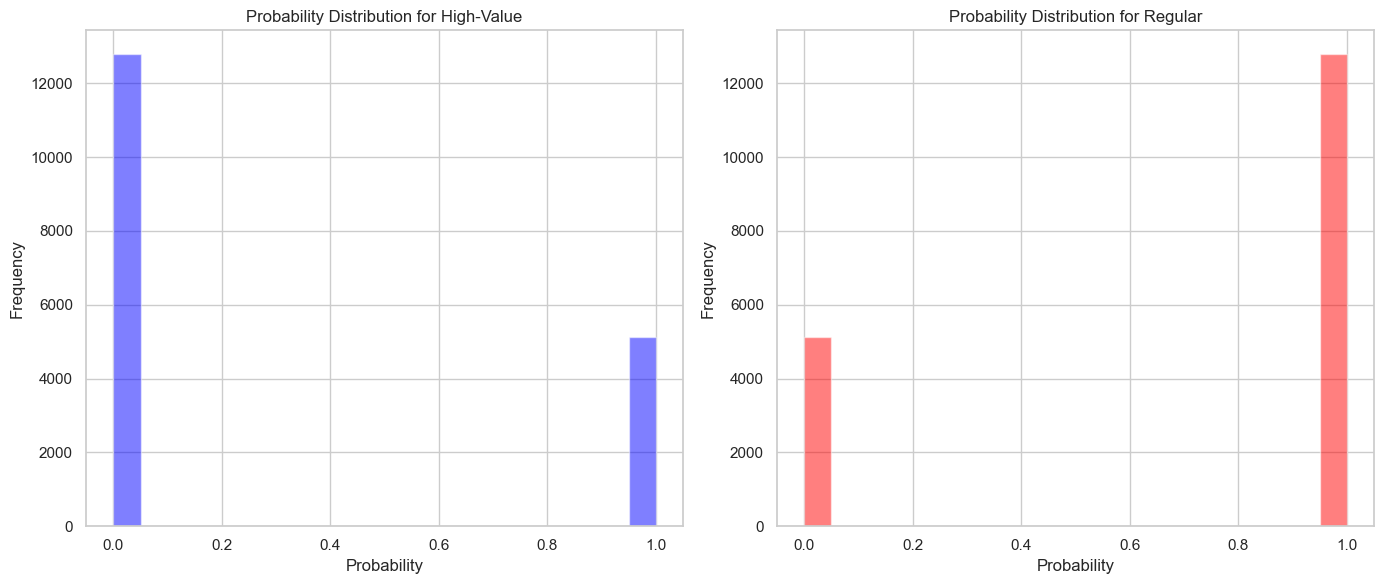

In [40]:
import pandas as pd
import matplotlib.pyplot as plt


predictions_pd = predictions.toPandas()

# Set the size of the plot for better visibility
plt.figure(figsize=(14, 6))

# Create a subplot for High-Value probabilities
plt.subplot(1, 2, 1)
plt.hist(predictions_pd['probability'].apply(lambda x: x[1]), bins=20, alpha=0.5, color='blue')
plt.title('Probability Distribution for High-Value')
plt.xlabel('Probability')
plt.ylabel('Frequency')

# Create a subplot for Regular probabilities
plt.subplot(1, 2, 2)
plt.hist(predictions_pd['probability'].apply(lambda x: x[0]), bins=20, alpha=0.5, color='red')
plt.title('Probability Distribution for Regular')
plt.xlabel('Probability')
plt.ylabel('Frequency')

# Show the plot with a tight layout to ensure no overlap of subplots
plt.tight_layout()
plt.show()



**From the histograms, we can see that:**

The 'High-Value' probabilities (on the left) have a concentration of frequencies at the lower probability values and another concentration at the higher probability values. This bimodal distribution suggests that the model is quite certain about a portion of the 'High-Value' predictions, while another portion is predicted with low probability.
The 'Regular' probabilities (on the right) are predominantly concentrated at the higher probability values. This indicates that the model is very confident in predicting regular sales, with most of the predicted probabilities close to 1.
These histograms provide a much clearer separation of the two predicted classes and can help in understanding the model's confidence in its predictions. It appears that the model is very confident in predicting 'Regular' sales, while it has a spread of confidence levels for 'High-Value' sales. This could be indicative of the model having a better grasp on the characteristics that define 'Regular' sales compared to 'High-Value' sales.

# Predicting Number of Car Owned Using Linear Regression 

**Objective:** To predict Number of Cars Owned by customers based on their yearly income and demographics 

In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# Load the dataset
file_path = 'C:/Users/rasman khurshid/Desktop/Data Processing/Dataset_Final/DataSet_final/DimCustomer.csv'
dim_customer_df = pd.read_csv(file_path, encoding='ISO-8859-1')

# Encoding 'CommuteDistance' as an ordinal variable based on its unique values
commute_distance_mapping = {
    '0-1 Miles': 1,
    '1-2 Miles': 2,
    '2-5 Miles': 3,
    '5-10 Miles': 4,
    '10+ Miles': 5
}
dim_customer_df['CommuteDistanceEncoded'] = dim_customer_df['CommuteDistance'].map(commute_distance_mapping)


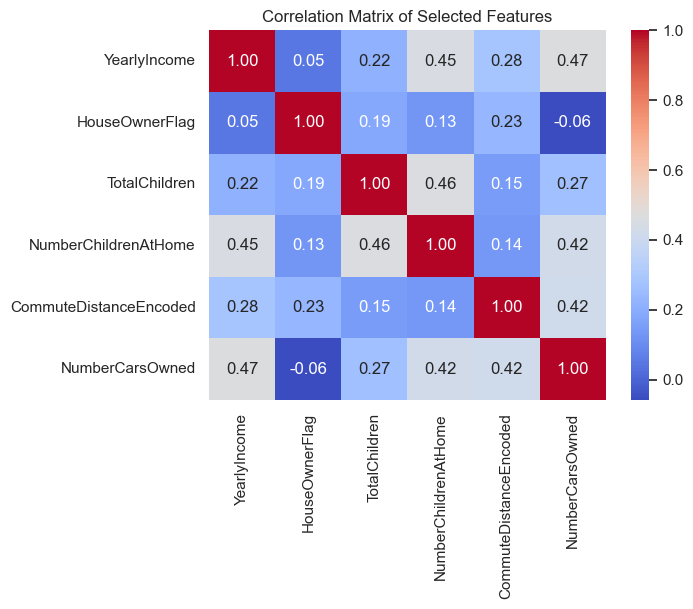

In [42]:
# EDA: Correlation Matrix and Heatmap
# Relevant columns for EDA
eda_columns = ['YearlyIncome', 'HouseOwnerFlag', 'TotalChildren', 
               'NumberChildrenAtHome', 'CommuteDistanceEncoded', 'NumberCarsOwned']
eda_df = dim_customer_df[eda_columns]
correlation_matrix = eda_df.corr()
#plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Selected Features")
plt.show()

In [43]:
# Printing the correlation matrix in a table format
correlation_matrix

,YearlyIncome,HouseOwnerFlag,TotalChildren,NumberChildrenAtHome,CommuteDistanceEncoded,NumberCarsOwned
YearlyIncome,1.000000,0.045714,0.215923,0.452133,0.282743,0.466647
HouseOwnerFlag,0.045714,1.000000,0.185742,0.130797,0.234869,-0.057983
TotalChildren,0.215923,0.185742,1.000000,0.461224,0.145090,0.265405
NumberChildrenAtHome,0.452133,0.130797,0.461224,1.000000,0.135145,0.424191
CommuteDistanceEncoded,0.282743,0.234869,0.145090,0.135145,1.000000,0.419836
NumberCarsOwned,0.466647,-0.057983,0.265405,0.424191,0.419836,1.000000


**Analysis**: The correlation matrix and heatmap provide a visual and numerical representation of the relationship between various features and the target variable 'NumberCarsOwned'. The heatmap uses color intensity to indicate the strength and direction of the correlation, where red tones represent positive correlations and blue tones represent negative correlations.

From the analysis, 'YearlyIncome' shows the strongest positive correlation (0.47) with the target variable, suggesting that as income increases, the number of cars owned tends to increase as well. 'NumberChildrenAtHome' also has a strong positive correlation (0.42) with 'NumberCarsOwned', which implies that households with more children at home may require more cars. 'CommuteDistanceEncoded' has a moderate positive correlation (0.42) with the target, indicating that longer commute distances might be associated with owning more cars. On the other hand, 'HouseOwnerFlag' has a negligible negative correlation (-0.06) with 'NumberCarsOwned', hinting that home ownership status might not be a significant predictor of car ownership in this dataset.

The correlation between 'YearlyIncome' and 'NumberCarsOwned' is particularly noteworthy as it suggests a potential avenue for predictive modeling. While correlation does not imply causation, these relationships provide a useful starting point for building regression models to predict car ownership. It's important to consider these insights in the context of the domain when selecting features for modeling and interpreting the results of any predictive analysis.

**Linear Regression**

In [44]:
# Proceeding with model training
# Preprocessing
relevant_columns = ['YearlyIncome', 'HouseOwnerFlag', 'TotalChildren', 
                    'NumberChildrenAtHome', 'CommuteDistanceEncoded', 'NumberCarsOwned']

# Note: Make sure 'CommuteDistanceEncoded' is treated as numerical if it's ordinal
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['YearlyIncome', 'TotalChildren', 'NumberChildrenAtHome', 'CommuteDistanceEncoded'])
    ])

# Separating features and target variable
X = dim_customer_df[relevant_columns[:-1]]  # Exclude 'NumberCarsOwned' from features
y = dim_customer_df['NumberCarsOwned']

# Applying transformations
X_transformed = preprocessor.fit_transform(X)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.3, random_state=42)

# Model Training
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Feature Importance Analysis
# Get the feature names after transformation
feature_names = preprocessor.named_transformers_['num'].get_feature_names_out()

# Combine feature names and coefficients from the model
feature_importances = pd.DataFrame(zip(feature_names, lr_model.coef_), 
                                   columns=['Feature', 'Coefficient'])

# Sort the features by the absolute magnitude of their coefficients
feature_importances['Absolute Coefficient'] = feature_importances['Coefficient'].abs()
feature_importances = feature_importances.sort_values(by='Absolute Coefficient', ascending=False)

# Predicting on the test set
y_pred = lr_model.predict(X_test)

# Model Evaluation
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

# Output the performance metrics
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R²):", r2)




Root Mean Squared Error (RMSE): 0.8984330489789496
R-squared (R²): 0.37653801700903866


Here's a step-by-step explanation of the code and its components:

**Preprocessing:**

relevant_columns are defined, which include both features and the target variable 'NumberCarsOwned'.
A ColumnTransformer with StandardScaler is set up to standardize the numerical features, which include 'YearlyIncome', 'TotalChildren', 'NumberChildrenAtHome', and 'CommuteDistanceEncoded'. Standardization is a common preprocessing step that scales the data so that it has a mean of 0 and a standard deviation of 1, helping to ensure that the scale of the features does not unduly influence the model.
Feature-Target Split:

The features (X) and the target variable (y) are separated. X includes all the relevant columns except for the target variable 'NumberCarsOwned'.
Data Transformation:

The features are transformed using the preprocessor, which standardizes the numerical features.
Train-Test Split:

The dataset is split into training and testing sets using train_test_split. This allows the model to be trained on one portion of the data and then evaluated on a separate portion to test its performance on unseen data. The test size is set to 30% of the data, with the random state fixed at 42 for reproducibility.
Model Training:

A LinearRegression model is instantiated and fitted to the training data. This model learns the relationship between the features and the target variable.
Feature Importance Analysis:

After training, the feature names are retrieved and combined with the model's coefficients, which represent the influence of each standardized feature on the target variable. The absolute values of these coefficients are calculated to assess the magnitude of the feature's impact, regardless of the direction (positive or negative).
Prediction and Evaluation:

The model is used to predict the target variable for the test set.
The model's performance is evaluated using two metrics: Root Mean Squared Error (RMSE) and R-squared (R²). RMSE measures the average magnitude of the errors between the predicted and actual values; a lower RMSE indicates better fit. R² measures the proportion of the variance in the target variable that can be explained by the model's features; an R² of 1 indicates perfect prediction, while an R² of 0 indicates that the model explains none of the variance.

**Analysis of Output:**

RMSE (0.8984): This value indicates the standard deviation of the prediction errors. In this context, it means that the model's predictions are, on average, 0.8984 units away from the actual number of cars owned. Whether this is acceptable depends on the context and the range of 'NumberCarsOwned' in the dataset.

R² (0.3765): This value suggests that approximately 37.65% of the variance in 'NumberCarsOwned' can be explained by the model. This is a moderate amount of variance explained, indicating the model has some predictive power, but there is still a significant amount of variance that the model does not account for.

The analysis implies that while the model has learned some of the underlying patterns in the data, there's room for improvement. Potential steps to improve the model could include feature engineering, considering non-linear models, or addressing potential outliers and leverage points.

## Confusion Matrix

In [57]:
y_pred_rounded = np.rint(y_pred)  # Round predictions to the nearest integer

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_rounded)

# Output the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[  55  984  167    7    0]
 [  21 1029  406   22    0]
 [  41 1063  799   68    2]
 [   0   19  260  196    5]
 [   0    6  190  190   16]]


**Class-wise Breakdown:**

Class 0 (First Row): 55 correct predictions, but 984 instances were incorrectly predicted as Class 1, 167 as Class 2, 7 as Class 3.
Class 1 (Second Row): 1029 correct predictions, but 21 instances were incorrectly predicted as Class 0, 406 as Class 2, 22 as Class 3.
Class 2 (Third Row): 799 correct predictions, with significant misclassifications into Classes 1 and 3.
Class 3 and Class 4 (Fourth and Fifth Rows): These classes have a higher number of misclassifications compared to correct predictions.
Implications:

The model seems to struggle most with accurately predicting Class 0, often confusing it with Class 1.
There is a considerable amount of confusion between Classes 1 and 2, and Classes 3 and 4.
The higher classes (like 3 and 4) have relatively few correct predictions, which might be due to a lower number of instances of these classes in the dataset (class imbalance).

**Possible Actions:**

Improve Class Imbalance: If there's a class imbalance in the dataset, techniques like oversampling the minority class, undersampling the majority class, or using class weights can help.
Feature Engineering: Look into creating or transforming features that might help the model distinguish between classes better.
Model Complexity: Consider whether a more complex model or different algorithms might capture the nuances between classes better.
Hyperparameter Tuning: Experiment with different hyperparameters to see if the model's performance can be improved.

## Feature Importance Analysis:
After training the model, checking the feature importances or coefficients to see which features are having the most impact on predictions.

In [45]:
# Displaying feature importances
feature_importances

,Feature,Coefficient,Absolute Coefficient
3,CommuteDistanceEncoded,0.344798,0.344798
0,YearlyIncome,0.292740,0.292740
2,NumberChildrenAtHome,0.272344,0.272344
1,TotalChildren,0.063826,0.063826


**Analyzing the feature importances:**

CommuteDistanceEncoded (Coefficient: 0.344798): This feature has the highest coefficient in absolute terms, which indicates that among the features used, 'CommuteDistanceEncoded' has the strongest relationship with the number of cars owned. Since this is a positive coefficient, a longer commute distance is associated with owning more cars.

YearlyIncome (Coefficient: 0.292740): 'YearlyIncome' is also a strong predictor of the number of cars owned, with the second-highest coefficient. The positive sign means that as yearly income increases, the number of cars owned tends to increase.

NumberChildrenAtHome (Coefficient: 0.272344): This feature has the third-highest impact on the number of cars owned. The positive coefficient suggests that households with more children at home are likely to own more cars.

TotalChildren (Coefficient: 0.063826): 'TotalChildren' has the smallest positive impact on the number of cars owned among the features listed. This indicates a weaker relationship compared to the other features.
'CommuteDistanceEncoded', 'YearlyIncome', and 'NumberChildrenAtHome' are the most significant predictors of car ownership in the model. The magnitude of these coefficients suggests that they are important factors to consider when predicting the number of cars a person or household owns.

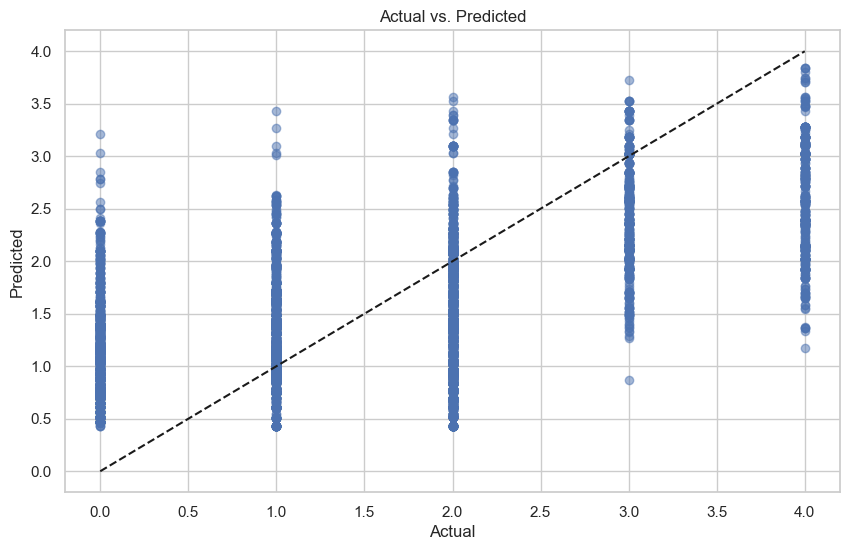

In [54]:
# Actual vs. Predicted plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--k')  # Diagonal line
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted')
plt.show()



**Actual vs. Predicted Plot:**

This plot displays the actual values of the target variable on the x-axis and the predicted values on the y-axis.
Ideal predictions would fall on the dashed diagonal line where the actual and predicted values are equal.
The plot shows that for most actual values, there are clusters of predicted values. This indicates that for any given actual value of 'NumberCarsOwned', there is a range of predictions, which suggests some inaccuracy in the model.
The clustering also suggests that the model may have difficulty distinguishing between different levels of the target variable, especially since the data points for actual values of 1, 2, and 3 cars seem to have overlapping predicted values.

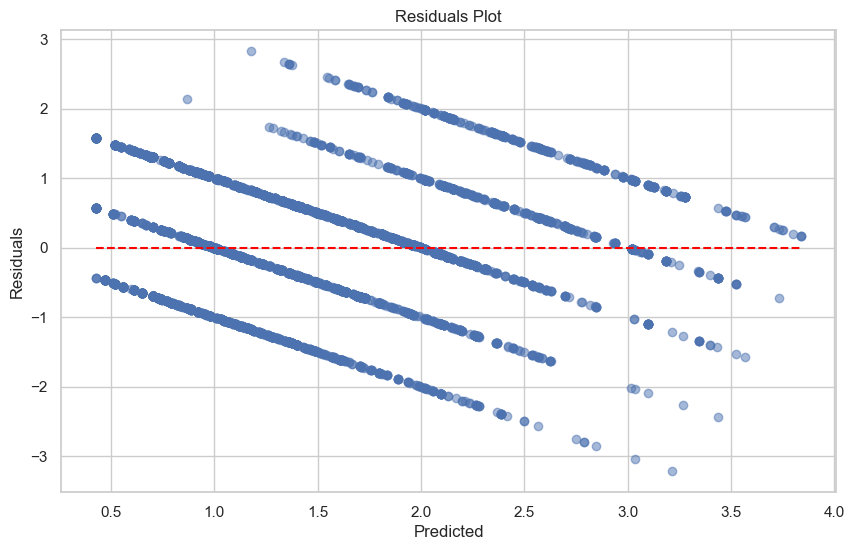

In [53]:
# Residuals plot
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), colors='red', linestyles='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()

**Residuals Plot:**

The residuals plot shows the residuals (the differences between the actual and predicted values) on the y-axis against the predicted values on the x-axis.
Ideally, residuals should be randomly scattered around the horizontal line at zero, indicating that the model's predictions are consistent across all values.
However, in this plot, we observe a clear pattern where the residuals do not scatter randomly but instead form distinct bands. This indicates systematic errors in the model's predictions.
The bands also suggest that the relationship between the predictors and the target may not be linear or that there may be other variables affecting the outcome that are not included in the model.

**Thats the End. Thank you** 